In [57]:
%matplotlib

Using matplotlib backend: MacOSX


In [58]:

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
sns.set_palette('colorblind')
sns.set_style('white')

In [59]:
import pandas as pd
import nltk
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.cross_validation import StratifiedShuffleSplit, train_test_split
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix 

In [60]:
from nltk.corpus import brown

In [61]:
from collections import Counter

In [62]:
def get_data():
    df = pd.read_csv('newtrain.csv')
    return df

In [76]:
def get_test_data():
    df = pd.read_csv('newtest.csv')
    return df

In [63]:
def add_features(df):

    #tokenize text
    pattern = r'''(?x)    # set flag to allow verbose regexps
         ([A-Z]\.)+        # abbreviations, e.g. U.S.A.
       | \w+([-']\w+)*        # words with optional internal hyphens
       | \$?\d+(\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
       | [!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+  # these are separate tokens (string.punctuation)
     '''
    tokenize = lambda text: nltk.regexp_tokenize(text, pattern)
    df['Tokens'] = df['Text'].apply(tokenize)
    
    def pos_tag(text):
        tuples = nltk.pos_tag(text)
        tags = []
        for t in tuples:
            tags.append(t[1])
        return tags
    def get_nouns(text):
        wnlemmatizer = nltk.WordNetLemmatizer()
        tuples = nltk.pos_tag(text)
        tags = []
        for t in tuples:
            if t[1][0] == 'N':
                tags.append(wnlemmatizer.lemmatize(t[0]))
        return tags
    df['Nouns'] = df['Tokens'].apply(get_nouns)
    df['POS'] = df['Tokens'].apply(pos_tag)
    make_string = lambda a: ' '.join(i for i in a)
    df['Nouns'] = df['Nouns'].apply(make_string)
    df['POS'] = df['POS'].apply(make_string)
    return df

In [78]:
#vectorize data
#turns words into a list of vectors - vector length is the total number of words
#Vector elements correspond to 1 word (1/0 if word is/not present in the current item)
def get_labels_features(df, max_f, targets=True):
    vec = CountVectorizer(analyzer = 'char_wb', ngram_range= (5,5), stop_words = ENGLISH_STOP_WORDS)
    vec_tar = LabelEncoder()
    if targets:
        targets = vec_tar.fit_transform(df['Category'])
    else:
        targets = []
        
    counts = vec.fit_transform(df['Text'])
    print("Counts shape: " + str(counts.shape))
    nouns = vec.fit_transform(df['Nouns'])
    print("Nouns shape: " + str(nouns.shape))
    pos = vec.fit_transform(df['POS'])
    print("POS shape: " + str(pos.shape))
    
    
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(counts)
    
    #To combine or not to combine
    nouns_array = nouns.toarray()
    pos_array = pos.toarray()
    combined = np.hstack((nouns_array, pos_array))
    return targets, tfidf

In [65]:
#evaluate using 10 fold cross-validation, inspect results
#KNN WITH CV#
def cross_validate(targets, features):
    #SVC
    mod = LinearSVC(C=.1)
    cv = StratifiedShuffleSplit(targets, n_iter=10, test_size=.1)

    scores = []
    for tr, tt in cv:
        mod.fit(features[tr], targets[tr])
        scores.append(mod.score(features[tt], targets[tt]))

    print('\nLinear SVC\n\t mean score: {0}'.format(np.mean(scores)))
    
    #svm
    #mod = SGDClassifier(loss = 'hinge',penalty = 'L2',alpha = 1e-3)
    #scores = []
    #for tr, tt in cv:
    #    mod.fit(features[tr], targets[tr])
    #    scores.append(mod.score(features[tt],targets[tt]))
    #print('\nLinear SVM\n\t mean score: {0}'.format(np.mean(scores)))
    
    
    
    #naive bayes
    mod = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
    scores = []
    for tr, tt in cv:
        mod.fit(features[tr], targets[tr])
        scores.append(mod.score(features[tt],targets[tt]))
    print('\nNaive Bayes\n\t mean score: {0}'.format(np.mean(scores)))
    
    
    logreg = LogisticRegression()
    scores = []
    for tr, tt in cv:
        logreg.fit(features[tr], targets[tr])
        scores.append(logreg.score(features[tt],targets[tt]))
    print('\nLogReg\n\t mean score: {0}'.format(np.mean(scores)))
    


In [66]:
df = get_data()
df = add_features(df)
df.head()

,Category,Text,Tokens,Nouns,POS
0,5,why are yawns contagious? when people yawn,"[why, are, yawns, contagious, when, people, yawn]",yawn people,WRB VBP NNS JJ WRB NNS VBP
1,6,what is trans fat? how to reduce that? i heard...,"[what, is, trans, fat, how, to, reduce, that, ...",trans tras body food,WP VBZ NNS JJ WRB TO VB IN PRP VBP IN NNS VBP ...
2,1,roth ira vs 401k? what is the difference betwe...,"[roth, ira, vs, 401k, what, is, the, differenc...",roth ira v difference roth ira prefer,NN NN NNS CD WP VBZ DT NN IN NN NN CC CD WRB M...
3,1,how many planes fedex has? i heard that it is ...,"[how, many, planes, fedex, has, i, heard, that...",plane fedex airline world,WRB JJ NNS NN VBZ PRP VBP IN PRP VBZ DT JJS NN...
4,2,what is the best photo slideshow creation appl...,"[what, is, the, best, photo, slideshow, creati...",photo slideshow creation application photo sli...,WP VBZ DT JJS NN NN NN NN WP VBZ DT JJS NN NN ...


In [80]:
result = get_labels_features(df, 1000)
labels = result[0]
x = result[1]
#cross_validate(labels, x)

Counts shape: (2698, 23364)
Nouns shape: (2698, 11762)
POS shape: (2698, 36)


In [68]:
#result = get_labels_features(df, 1000)
#labels = result[0]
#x = result[1]
#cross_validate(labels, x)

In [69]:
#result = get_labels_features(df, 1000)
#labels = result[0]
#x = result[1]
#cross_validate(labels, x)


In [70]:
def plot_confusion_matrix(cm, title, target_names, cmap=plt.cm.coolwarm):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [71]:
def examine_classification(model):
    result = get_labels_features(df, 1000)
    y = result[0]
    x = result[1]
    xtrain, xtest, ytrain, ytest = train_test_split(x, labels, test_size=0.33, random_state=99)
    
    model.fit(xtrain, ytrain)
    ypredicted = model.predict(xtest)
    print(accuracy_score(ytest, ypredicted))
    print()
    print(pd.crosstab(ytest, ypredicted, 
            rownames=['True'], colnames=['Predicted'], 
            margins=True))
    print()
    cm = confusion_matrix(ytest, ypredicted)
    plot_confusion_matrix(cm, "Confusion Matrix", range(8))

Counts shape: (2698, 23364)
Nouns shape: (2698, 11762)
POS shape: (2698, 36)
0.597081930415

Predicted    0    1    2    3   4   5   6  All
True                                          
0          144   29   34   25   7   6   9  254
1           23  124    4    2   1   1   0  155
2           24    9   84    7   2   1   2  129
3           11    3    4   91   0   3   2  114
4           29    9    9    2  20   2   2   73
5           20   10    3   10   1  35   1   80
6           24    6    8    3   6   5  34   86
All        275  190  146  140  37  53  50  891



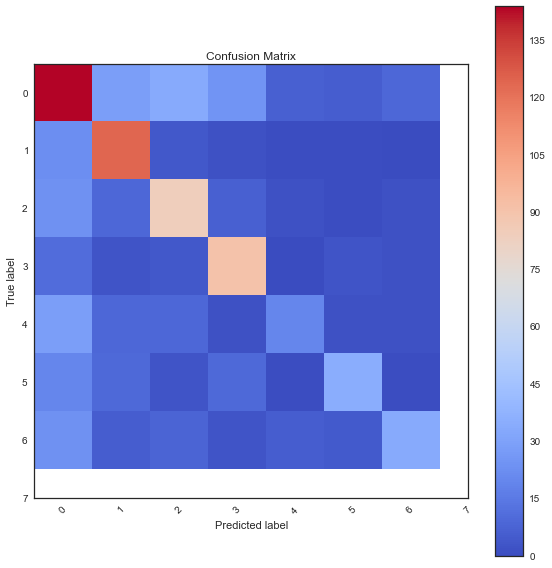

In [72]:
examine_classification(SGDClassifier(loss = 'hinge',penalty = 'L2',alpha = 1e-3))


In [81]:
test_df = get_test_data()
test_df = add_features(test_df)
result = get_labels_features(test_df, 1000, targets=False)
test = result[1]

Counts shape: (1874, 18321)
Nouns shape: (1874, 9193)
POS shape: (1874, 36)


In [82]:
mod = LogisticRegression()
mod.fit(x, labels)
predictions = mod.predict(test)

ValueError: X has 18321 features per sample; expecting 23364

In [ ]:
import csv
with open('submission.csv', 'wb') as f:
    writer = csv.writer(f)
    writer.writerow('ID', 'Category')
    for i, p in enumerate(predictions):
        writer.writerow(i, p)